In [ ]:
using Plots
using Statistics

# Lezione 10: Generatori di numeri casuali

## Esercizio 10.1

In Julia non esiste il concetto di «classe», ma esistono le `struct` che funzionano in modo concettualmente simile. Non permettono di associare metodi, tranne eventualmente un semplice costruttore. Definiamo una classe GLC che sia equivalente alla classe `Random` che vi viene richiesto di implementare.

In [2]:
# Generatore Lineare Congruenziale
mutable struct GLC
    a::UInt64
    c::UInt64
    m::UInt64
    seed::UInt64
    
    GLC(myseed) = new(1664525, 1013904223, 1 << 31, myseed)
end

"""
    rand(glc::GLC, xmin, xmax)

Return a pseudo-random number uniformly distributed in the
interval [xmin, xmax).
"""
function rand(glc::GLC, xmin, xmax)
    glc.seed = (glc.a * glc.seed + glc.c) % glc.m
    xmin + (xmax - xmin) * glc.seed / glc.m
end

"""
    rand(glc::GLC)

Return a pseudo-random number uniformly distributed in the
interval [0, 1).
"""
rand(glc::GLC) = rand(glc, 0.0, 1.0)

"""
    randexp(glc::GLC)

Return a positive pseudo-random number distributed with a
probability density ``p(x) = λ e^{-λ x}``.
"""
randexp(glc::GLC, λ) = -log(rand(glc)) * λ

@doc raw"""
    randgauss(glc::GLC, μ, σ)

Return a pseudo-random number distributed with a probability
density ``p(x) = \frac{1}{\sqrt{2πσ^2}}\exp\left(-\frac{(x - μ)^2}{2σ^2}\right)``,
using the Box-Müller algorithm.
"""
function randgauss(glc::GLC, μ, σ)
    s = rand(glc)
    t = rand(glc)
    x = sqrt(-2log(s)) * cos(2π * t)
    μ + σ * x
end

@doc raw"""
    randgauss_ar(glc::GLC, μ, σ)

Return a pseudo-random number distributed with a probability
density ``p(x) = \frac1{\sqrt{2πσ^2}}\exp\left(-\frac{(x - μ)^2}{2σ^2}\right)``,
using the accept-reject algorithm.
"""
function randgauss_ar(glc::GLC, μ, σ)
    while true
        x = rand(glc, -5., 5.)
        y = rand(glc)
        g = exp(-x^2 / 2)
        y ≤ g && return μ + x * σ
    end
end

randgauss_ar

Tutte le funzioni definite sopra forniscono una guida, invocabile col carattere `?` seguito dal nome della funzione:

In [3]:
?randgauss

search: randgauss randgauss_ar



```
randgauss(glc::GLC, μ, σ)
```

Return a pseudo-random number distributed with a probability density $p(x) = \frac{1}{\sqrt{2πσ^2}}\exp\left(-\frac{(x - μ)^2}{2σ^2}\right)$, using the Box-Müller algorithm.


Questi sono i numeri che dovreste aspettarvi se avete implementato bene il vostro codice (notate che i numeri cambiano se usate un seed diverso!).

In [4]:
glc = GLC(1)
for i in 1:5
    println(i, ": ", rand(glc))
end

1: 0.47291105054318905
2: 0.7385413474403322
3: 0.008484064601361752
4: 0.40976652735844254
5: 0.10108725726604462


Quando si implementano numeri pseudo-casuali, è sempre bene farsi un'idea della distribuzione dei valori. Disegnamo quindi l'istogramma della distribuzione di un gran numero di campioni, e verifichiamo che siano uniformemente distribuiti nell'intervallo [0, 1).

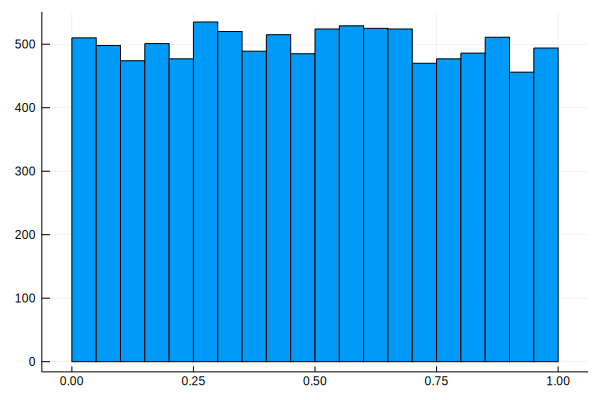

In [5]:
histogram([rand(glc) for i in 1:10000], label="")

Facciamo ora la stessa cosa con le altre distribuzioni.

In [6]:
glc = GLC(1)
for i in 1:5
    println(i, ": ", randexp(glc, 1))
end

1: 0.748847961994437
2: 0.3030781901686082
3: 4.769565627815321
4: 0.8921677269466443
5: 2.2917712017892984


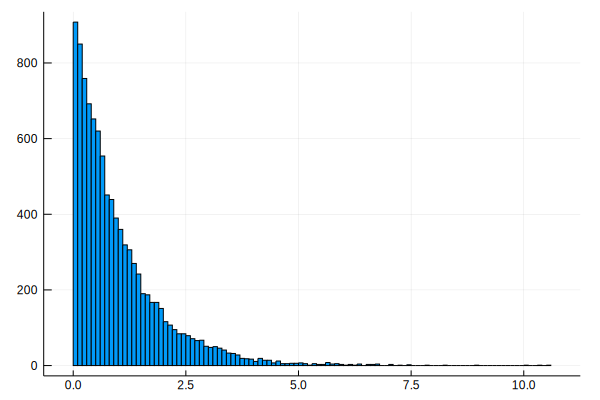

In [7]:
histogram([randexp(glc, 1) for i in 1:10000], label="")

In [7]:
glc = GLC(1)
for i in 1:5
    println(i, ": ", randgauss(glc, 2, 1))
end

1: 1.9119660920460757
2: -0.6053171651252578
3: 1.8526405678280609
4: 2.8326279901403026
5: 1.5348644738998436


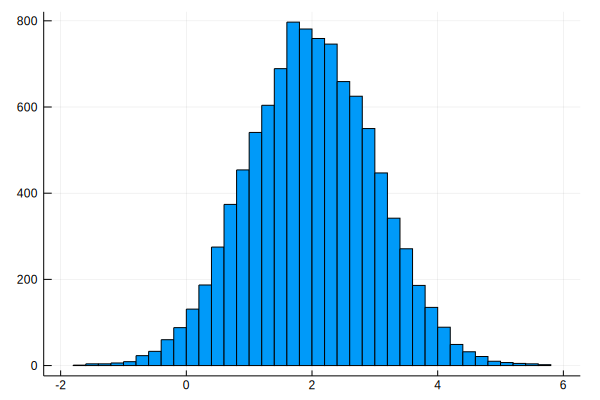

In [9]:
histogram([randgauss(glc, 2, 1) for i in 1:10000], label="")

In [8]:
glc = GLC(1)
for i in 1:5
    println(i, ": ", randgauss_ar(glc, 2, 1))
end

1: 1.7291105054318905
2: 2.4952592495828867
3: 2.009022830054164
4: 0.6520544346421957
5: 1.318840131163597


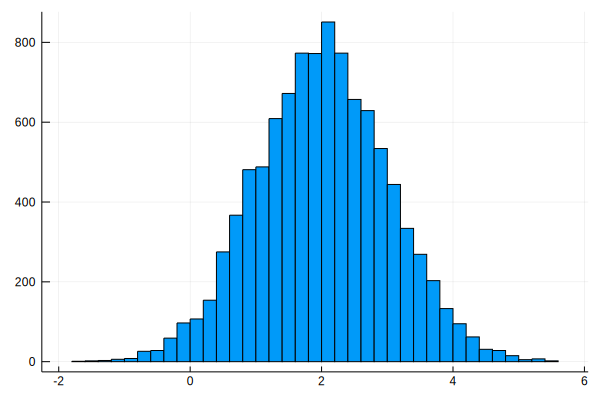

In [9]:
histogram([randgauss_ar(glc, 2, 1) for i in 1:10000], label="")

## Esercizio 10.2

In [10]:
"""
    intmean(glc::GLC, fn, a, b, N)

Evaluate the integral of `fn(x)` in the interval ``[a, b]``
using the mean method with ``N`` points.
"""
intmean(glc::GLC, fn, a, b, N) = (b - a) * sum([fn(rand(glc, a, b)) for i in 1:N]) / N

"""
    inthm(glc::GLC, fn, a, b, fmax, N)

Evaluate the integral of `fn(x)` in the interval ``[a, b]``
using the hit-or-miss method with ``N`` points, assuming that
`fn(x)` assumes values in the range `[0, fmax]`.
"""
function inthm(glc::GLC, fn, a, b, fmax, N)
    hits = 0
    for i in 1:N
        x = rand(glc, a, b)
        y = rand(glc, 0, fmax)
        y ≤ fn(x) && (hits += 1)
    end
    
    hits / N * (b - a) * fmax
end

inthm

Verifichiamo che il codice compili, e che produca un risultato sensato. Teniamo presente che $\int_0^\pi \sin x\,\mathrm{d}x = 2$; inoltre, siccome $\sin(x)$ è una funzione limitata in $[0, 1]$, possiamo porre `fmax=1` nella chiamata a `inthm`:

In [11]:
glc = GLC(1)
println("Integrale (metodo media):", intmean(glc, sin, 0, π, 100))
println("Integrale (metodo hit-or-miss):", inthm(glc, sin, 0, π, 1, 100))

Integrale (metodo media):1.8715046084621125
Integrale (metodo hit-or-miss):2.0734511513692637


Eseguiamo ora il calcolo per 10.000 volte e facciamone l'istogramma: osserviamo che la distribuzione è approssimativamente una Gaussiana, come previsto.

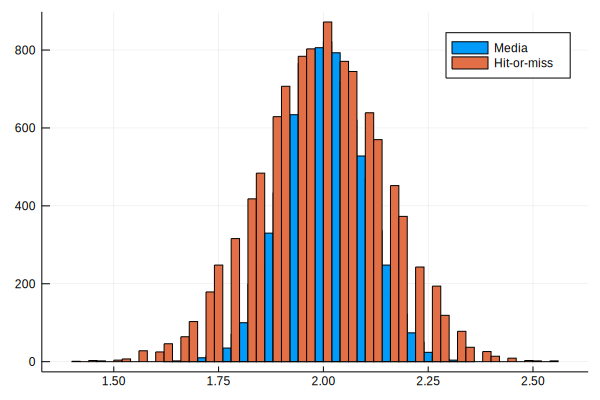

In [12]:
mean_samples = [intmean(glc, sin, 0, π, 100) for i in 1:10_000]
mean_hm = [inthm(glc, sin, 0, π, 1, 100) for i in 1:10_000]
histogram(mean_samples, label="Media")
histogram!(mean_hm, label="Hit-or-miss")

Se l'andamento dell'errore è della forma $\epsilon(N) = k/\sqrt{N}$, con $N$ numero di punti, allora nel nostro caso possiamo stimare $k$ immediatamente dalla deviazione standard dei valori in `values` mediante la formula $k = \sqrt{N} \times \epsilon(N)$:

In [13]:
k_mean = √100 * std(mean_samples)
k_hm = √100 * std(mean_hm)

println("K (media) = ", k_mean)
println("K (hit-or-miss) = ", k_hm)

K (media) = 0.9575173957724342
K (hit-or-miss) = 1.5068144324183006


A questo punto, per rispondere alla domanda del problema, è sufficiente risolvere l'equazione $0.001 = k/\sqrt{N}$ per $N$, ossia $$N = \left(\frac{k}{0.001}\right)^2$$.

In [14]:
noptim_mean = round(Int, (k_mean/0.001)^2)
noptim_hm = round(Int, (k_hm/0.001)^2)

println("N (media) = ", noptim_mean)
println("N (hit-or-miss) = ", noptim_hm)

N (media) = 916840
N (hit-or-miss) = 2270490


Per verificare la correttezza del risultato, rifacciamo l'istogramma. Siccome ci vuole molto tempo per ottenere il risultato, verifichiamo il risultato solo nel caso del metodo della media, e per un numero ridotto di realizzazioni (1000 anziché 10.000):

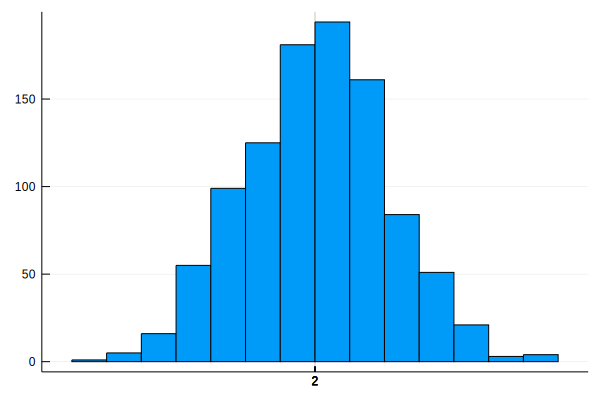

In [15]:
values = [intmean(glc, sin, 0, π, noptim_mean) for i in 1:1000]
histogram(values, label="")

Il risultato è effettivamente corretto:

In [16]:
std(values)

0.0010318748779372456

# Lezione 11: Metodi Monte Carlo

## Esercizio 11.1

In [17]:
σ_θ = 0.3e-3;
θ0_ref = π / 2;
Aref = 2.7;
Bref = 60_000e-18;
α = deg2rad(60.0);
λ1 = 579.1e-9;
λ2 = 404.7e-9;

La funzione `n_cauchy` restituisce $n$ supponendo vera la formula di Cauchy. La sintassi con un parametro usa i valori di riferimento di $A$ e $B$ scritti sopra.

In [18]:
n_cauchy(λ, A, B) = sqrt(A + B / λ^2)
n_cauchy(λ) = n_cauchy(λ, Aref, Bref)

n_cauchy (generic function with 2 methods)

La funzione `n` invece restituisce $n$ in funzione della deviazione misurata dal prisma, dove $\alpha$ è il suo angolo di apertura (definito sopra).

In [19]:
n(δ) = sin((δ + α) / 2) / sin(α / 2)
δ(n) = 2asin(n * sin(α / 2)) - α

δ (generic function with 1 method)

Queste formule si ricavano banalmente dall'inversione della formula di Cauchy; la funzione `A_and_B` calcola contemporaneamente $A$ e $B$, ed è stata definita per comodità:

In [20]:
A(λ1, δ1, λ2, δ2) = (λ2^2 * n(δ2)^2 - λ1^2 * n(δ1)^2) / (λ2^2 - λ1^2)
B(λ1, δ1, λ2, δ2) = (n(δ2)^2 - n(δ1)^2) / (1/λ2^2 - 1/λ1^2)
A_and_B(λ1, δ1, λ2, δ2) = (A(λ1, δ1, λ2, δ2), B(λ1, δ1, λ2, δ2))

A_and_B (generic function with 1 method)

Calcoliamo allora i valori di riferimento di $n(\lambda_1) = n_1$ e $n(\lambda_2) = n_2$, supponendo veri i valori di $A$ e $B$ scritti sopra (`A_ref` e `B_ref`):

In [21]:
n1_ref, n2_ref = n_cauchy(λ1), n_cauchy(λ2)

(1.6967362539886182, 1.751096919705952)

Da $n_1$ e $n_2$ calcoliamo quanto aspettarci per $\delta_1$ e $\delta_2$:

In [22]:
δ1_ref, δ2_ref = δ(n1_ref), δ(n2_ref)

(0.9785928129680508, 1.0859421943701004)

A questo punto possiamo simulare l'esperimento. La simulazione della misura di $\delta_1$ e $\delta_2$ va fatta usando l'approssimazione Gaussiana con i valori medi `δ1_ref` e `δ2_ref`, e la deviazione standard `σ_θ` data dal testo dell'esercizio:

In [23]:
function simulate_experiment(glc, nsim)
    n1_simul = Array{Float64}(undef, nsim)
    n2_simul = Array{Float64}(undef, nsim)
    
    A_simul = Array{Float64}(undef, nsim)
    B_simul = Array{Float64}(undef, nsim)
    
    for i in 1:nsim
        θ0 = randgauss(glc, θ0_ref, σ_θ)
        θ1, θ2 = randgauss(glc, θ0_ref + δ1_ref, σ_θ), randgauss(glc, θ0_ref + δ2_ref, σ_θ)
        δ1, δ2 = θ1 - θ0, θ2 - θ0
        n1, n2 = n(δ1), n(δ2)
        a, b = A_and_B(λ1, δ1, λ2, δ2)
        
        n1_simul[i] = n1
        n2_simul[i] = n2
        
        A_simul[i] = a
        B_simul[i] = b
    end
    
    (n1_simul, n2_simul, A_simul, B_simul)
end

simulate_experiment (generic function with 1 method)

Ecco i primi 5 valori della simulazione; controllate che siano gli stessi che ottenete voi, facendo attenzione di usare come seed 1 e che l'ordine in cui chiamate la funzione per generare i numeri casuali sia la stessa del codice sopra:
1. *Prima* si genera $\theta_0$;
2. *Poi* si generano $\theta_1$ e $\theta_2$.

Nel fare i plot qui sotto mi limito a ripetere l'esperimento 1000 volte (il testo richiede 10.000 volte). I risultati non cambiano molto.

In [24]:
glc = GLC(1)
n1_simul, n2_simul, A_simul, B_simul = simulate_experiment(glc, 1000)

for i = 1:5
    println("n1 = $(n1_simul[i]), n2 = $(n2_simul[i]), A = $(A_simul[i]), B = $(B_simul[i])")
end

n1 = 1.6963363330066135, n2 = 1.751088321048983, A = 2.697376455358684, B = 6.042475747604193e-14
n1 = 1.6965301084067972, n2 = 1.7510718183787763, A = 2.6987166730704044, B = 6.019578803328657e-14
n1 = 1.6970607639880195, n2 = 1.7511536536290313, A = 2.701962950055681, B = 5.971104685137892e-14
n1 = 1.6965805446883164, n2 = 1.750721001236658, A = 2.700223865224527, B = 5.974773246459977e-14
n1 = 1.6969765991389545, n2 = 1.7511371019478696, A = 2.701459942853605, B = 5.978393617101409e-14


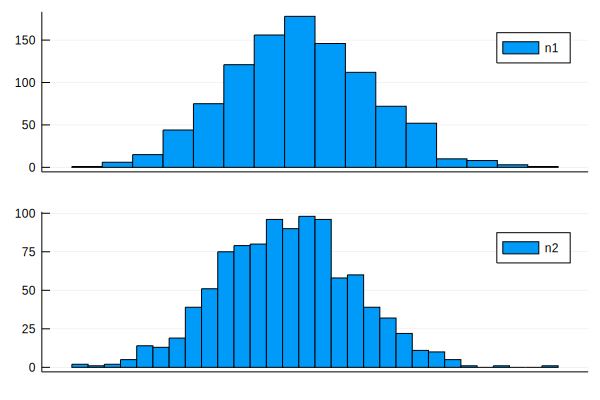

┌ Warning: No strict ticks found
└ @ PlotUtils /home/tomasi/.julia/packages/PlotUtils/EybJR/src/ticks.jl:168
┌ Warning: No strict ticks found
└ @ PlotUtils /home/tomasi/.julia/packages/PlotUtils/EybJR/src/ticks.jl:168
┌ Warning: No strict ticks found
└ @ PlotUtils /home/tomasi/.julia/packages/PlotUtils/EybJR/src/ticks.jl:168
┌ Warning: No strict ticks found
└ @ PlotUtils /home/tomasi/.julia/packages/PlotUtils/EybJR/src/ticks.jl:168
┌ Warning: No strict ticks found
└ @ PlotUtils /home/tomasi/.julia/packages/PlotUtils/EybJR/src/ticks.jl:168
┌ Warning: No strict ticks found
└ @ PlotUtils /home/tomasi/.julia/packages/PlotUtils/EybJR/src/ticks.jl:168
┌ Warning: No strict ticks found
└ @ PlotUtils /home/tomasi/.julia/packages/PlotUtils/EybJR/src/ticks.jl:168
┌ Warning: No strict ticks found
└ @ PlotUtils /home/tomasi/.julia/packages/PlotUtils/EybJR/src/ticks.jl:168


In [25]:
histogram([n1_simul, n2_simul], label = ["n1" "n2"], layout = (2, 1))

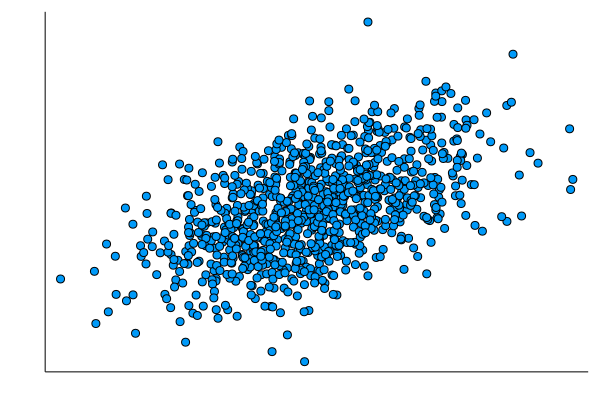

┌ Warning: No strict ticks found
└ @ PlotUtils /home/tomasi/.julia/packages/PlotUtils/EybJR/src/ticks.jl:168
┌ Warning: No strict ticks found
└ @ PlotUtils /home/tomasi/.julia/packages/PlotUtils/EybJR/src/ticks.jl:168
┌ Warning: No strict ticks found
└ @ PlotUtils /home/tomasi/.julia/packages/PlotUtils/EybJR/src/ticks.jl:168
┌ Warning: No strict ticks found
└ @ PlotUtils /home/tomasi/.julia/packages/PlotUtils/EybJR/src/ticks.jl:168
┌ Warning: No strict ticks found
└ @ PlotUtils /home/tomasi/.julia/packages/PlotUtils/EybJR/src/ticks.jl:168
┌ Warning: No strict ticks found
└ @ PlotUtils /home/tomasi/.julia/packages/PlotUtils/EybJR/src/ticks.jl:168
┌ Warning: No strict ticks found
└ @ PlotUtils /home/tomasi/.julia/packages/PlotUtils/EybJR/src/ticks.jl:168
┌ Warning: No strict ticks found
└ @ PlotUtils /home/tomasi/.julia/packages/PlotUtils/EybJR/src/ticks.jl:168


In [26]:
scatter(n1_simul, n2_simul, label="")

Il package `Statistics` di Julia implementa il calcolo della covarianza tra due serie, che è uguale alla correlazione a meno di una normalizzazione. Definiamo quindi la funzione `corr`, che calcola il coefficiente di correlazione, analogamente a questa; nel vostro codice C++ dovrete invece implementarla usando la formula.

In [27]:
corr(x, y) = cov(x, y) / (std(x) * std(y))

corr (generic function with 1 method)

I valori di $n_1$ ed $n_2$ sono correlati, perché sono entrambi stati ricavati dalla medesima stima di $\theta_0$.

In [28]:
corr(n1_simul, n2_simul)

0.5141392923977202

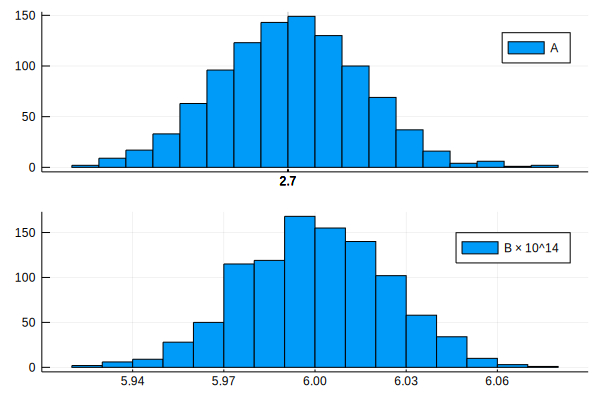

In [29]:
histogram([A_simul, B_simul * 1e14], label = ["A" "B × 10^14"], layout = (2, 1))

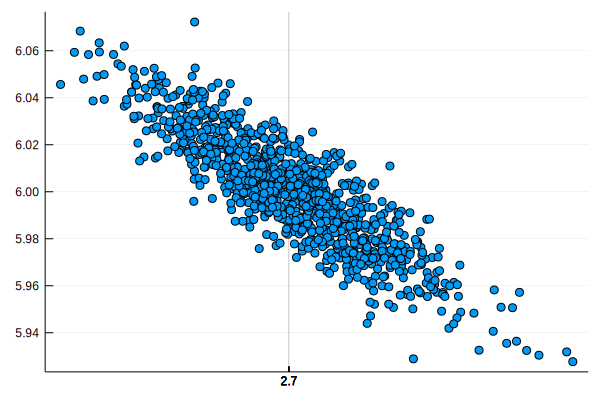

In [30]:
scatter(A_simul, B_simul * 1e14, label="")

Vengono qui ricalcolati i coefficienti di correlazione nel caso in cui l'esperimento sia rifatto 10.000 volte. Notate che creo di nuovo un generatore di numeri casuali.

In [31]:
glc = GLC(1)
(n1_simul, n2_simul, A_simul, B_simul) = simulate_experiment(glc, 10_000)
println("Correlazione tra n1 e n2: ", corr(n1_simul, n2_simul))
println("Correlazione tra A e B: ", corr(A_simul, B_simul))

Correlazione tra n1 e n2: 0.4989310019409708
Correlazione tra A e B: -0.8706760061112585
